# The Nyquist condition in the eye diagram

**System model**: BPSK source -> RRC pusle shaping -> Matched Filter -> Eye diagram

In [1]:
%matplotlib inline

import random
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import matplotlib
kitgreen = (0, 150/255, 130/255)
import rrc

N = 128  # number of symbols
M = 16  # samples per symbol (oversampling factor)
K = 128  # length of impulse response in symbols
rho = np.array([0])  # RRC Rolloff factor
sigma2_N = 0  # noise variance

## Symbol generation

In [2]:
sym = [random.choice([-1, 1]) for i in range(N)]  # BPSK symbols
sym_up = np.zeros(M*N)
sym_up[::M] = sym  # upsampled symbols

## Puls-shaping filter (Root Raised Cosine)

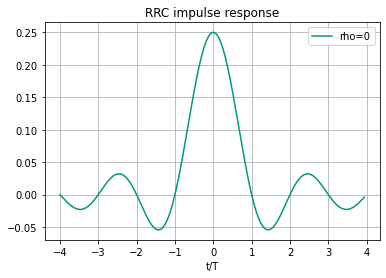

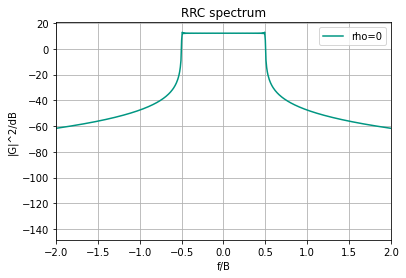

In [3]:
# generate normalized RRC pulse
N_rrc = M*K+1
RRC_group_delay = int((N_rrc-1)/2)
for r in rho:
    g = rrc.get_rrc_ir(N_rrc, M, 1, r)
    g /= np.sqrt(np.sum(g**2))

    # create TX signal
    s = np.convolve(sym_up, g, mode='full')

    # plot pulse impulse response and spectrum
    Kplot = min(K//2, 4)
    plt.figure("pulseshape")
    plt.plot(np.arange(-Kplot, Kplot, 1/M), g[len(g)//2-Kplot*M: len(g)//2+Kplot*M],label="rho="+str(r), color=kitgreen); 
    plt.title("RRC impulse response"); plt.xlabel('t/T'); plt.grid(True);plt.legend()

    plt.figure("something")
    G = np.fft.fftshift(np.fft.fft(g))
    f = np.linspace(-M//2, M//2, len(G))
    G_dB = 10*np.log10(np.abs(G)**2)
    plt.plot(f, G_dB, label="rho="+str(r), color=kitgreen); plt.title("RRC spectrum")
    plt.xlim(-2, 2); plt.grid(True); plt.xlabel('f/B'); plt.ylabel('|G|^2/dB'); plt.legend()#plt.ylim(-60, 15); 

## Generating Rx signal

In [4]:
# simulate AWGN channel
n = np.sqrt(sigma2_N) * np.random.randn(s.size)
r = s + n

# perform matched filtering
h = g  # matched filter is equal to the pulse shaping filter due to symmetry
#h = rrc.get_rrc_ir(N_rrc, M, 1, 1)  # use this to experiment with "unmatched" filters
#h /= np.sqrt(np.sum(h**2))
y = np.convolve(r, h)

## Complete filter (transmit and receive filter)

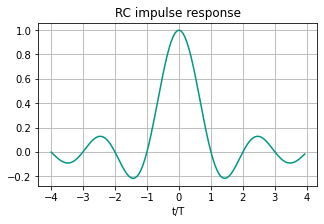

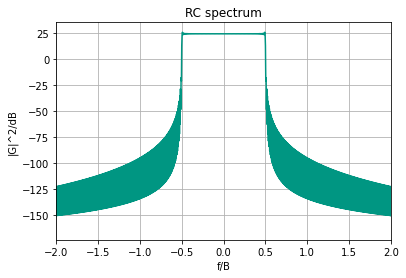

In [5]:
# convolve TX and RX pulse shape
g_total = np.convolve(g, h)

# plot impulse response and spectrum
plt.figure(figsize=[5,3])
plt.plot(np.arange(-Kplot, Kplot, 1/M), g_total[len(g_total)//2-Kplot*M: len(g_total)//2+Kplot*M], color=kitgreen); 
plt.title("RC impulse response"); plt.xlabel('t/T'); plt.grid();
plt.savefig("rc_ir.pdf")

plt.figure()
G_total = np.fft.fftshift(np.fft.fft(g_total))
f = np.linspace(-M//2, M//2, len(G_total))
#plt.semilogy(f, np.abs(G_total)**2); plt.title("RC spectrum")
#plt.xlim(-2, 2); plt.grid(); plt.ylim(1e-1, 1e3); plt.xlabel('f/B');
G_total_dB = 20*np.log10(np.abs(G_total))
plt.plot(f, G_total_dB, color=kitgreen); plt.title("RC spectrum")
plt.xlim(-2, 2); plt.grid(); plt.xlabel('f/B'); plt.ylabel('|G|^2/dB'); #plt.ylim(-100, 30); 

## Eye diagram

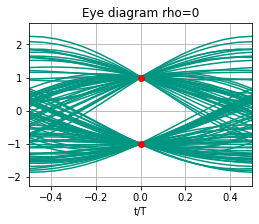

In [6]:
# overlay slices of length T to generate an eye diagram
delay = (g.size - 1)//2 + (h.size - 1)//2 + M//2
ntraces = 100
traces = np.zeros((M+1, ntraces))
for i in range(ntraces):
    traces[:, i] = y[delay + i*M: delay + (i+1)*M + 1]
plt.figure(figsize=[4,3])
plt.plot(np.linspace(-0.5, 0.5, M+1), traces, color=kitgreen)
plt.margins(y=0.1, x=0)
plt.xlabel('t/T')
plt.title("Eye diagram rho="+str(rho[0]))
plt.grid()
plt.plot(0, 1, 'or'); plt.plot(0, -1, 'or');
plt.savefig("eye_rc_0.pdf")